## Import Libraries

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

## Import Data

In [5]:
df = pd.read_excel('premiums_rest.xlsx')

print(f'The number of Rows is {df.shape[0]}')
print(f'The number of Cols is {df.shape[1]}')

The number of Rows is 29904
The number of Cols is 13


In [6]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [7]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

## Data Cleaning

### Handle NA values

In [8]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.shape

(29886, 13)

In [11]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicates

In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### Handle outliers

In [14]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


#### Handle Outliers : number_of_dependants

In [15]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-1, -3])

In [16]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

#### Handle Outliers : numerical columns

In [17]:
numerical_cols = df.select_dtypes(['float64', 'int64']).columns
numerical_cols

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

In [18]:
def boxPlots(data, cols):
    for col in cols:
        sns.boxplot(data, x=col)
        plt.show()

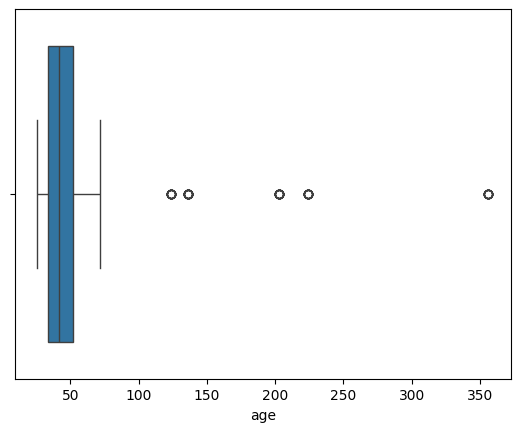

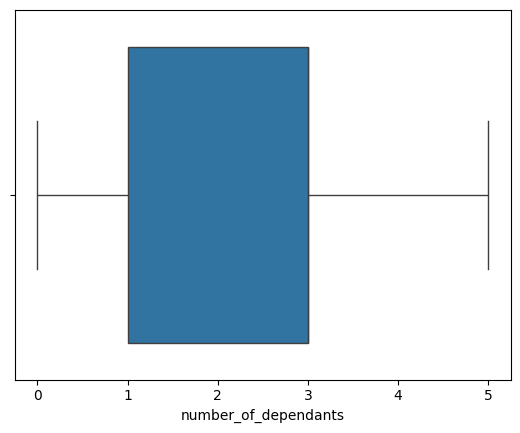

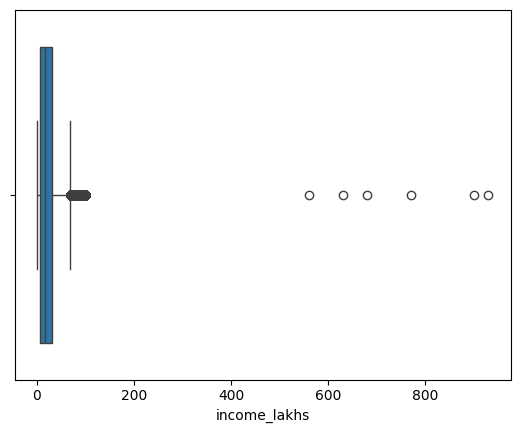

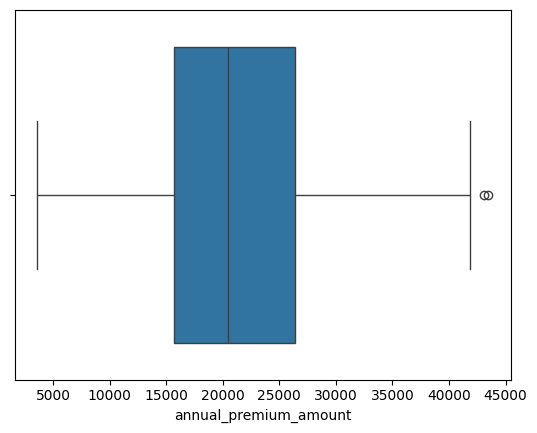

In [19]:
boxPlots(df, numerical_cols)

##### Handle Outliers : numerical columns (age)

In [20]:
df[df.age > 100].shape

(58, 13)

In [21]:
df1 = df[df.age < 100].copy()

In [22]:
df1.shape

(29828, 13)

In [23]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


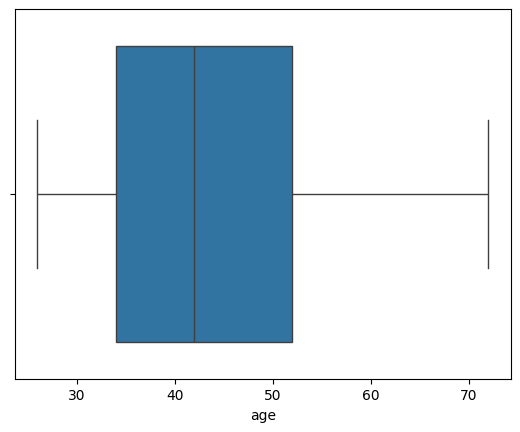

In [24]:
boxPlots(df1, ['age'])

##### Handle Outliers : numerical columns (income_lakhs)

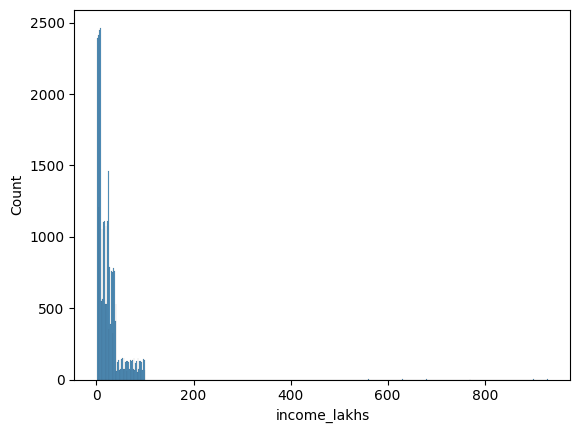

In [25]:
sns.histplot(df1, x='income_lakhs')
plt.show()

In [26]:
def get_iqr_bounds(col):
    q1, q3 = col.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [27]:
lower_bound, upper_bound = get_iqr_bounds(df1['income_lakhs'])
lower_bound, upper_bound

(-30.5, 69.5)

In [28]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [29]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.shape

(29822, 13)

In [30]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


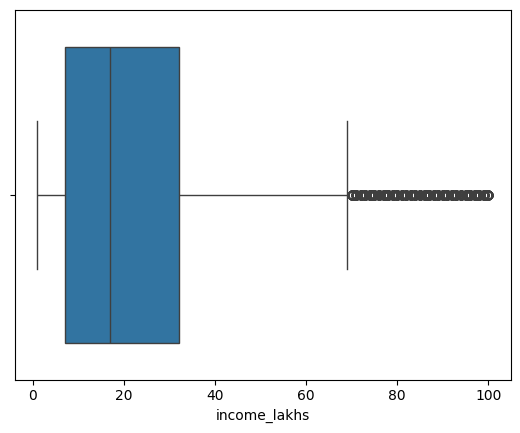

In [31]:
boxPlots(df2, ['income_lakhs'])

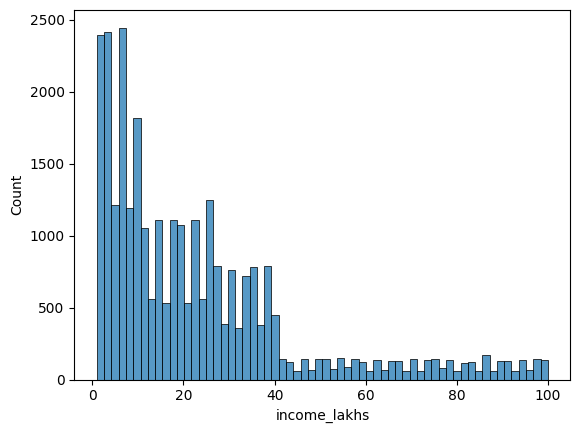

In [32]:
sns.histplot(df2, x='income_lakhs')
plt.show()

## Data Analysis

### Data Analysis : numerical columns

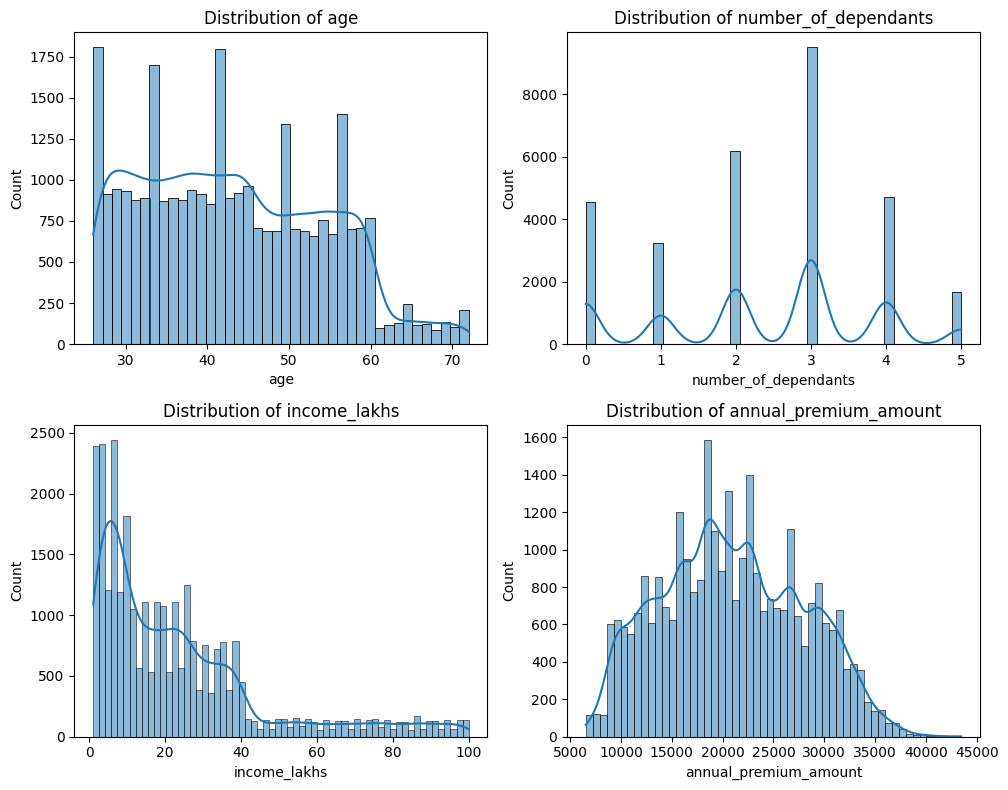

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid

for ax, col in zip(axes.flatten(), numerical_cols[:4]):  # [:4] just in case you have more than 4
    sns.histplot(df2, x=col, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

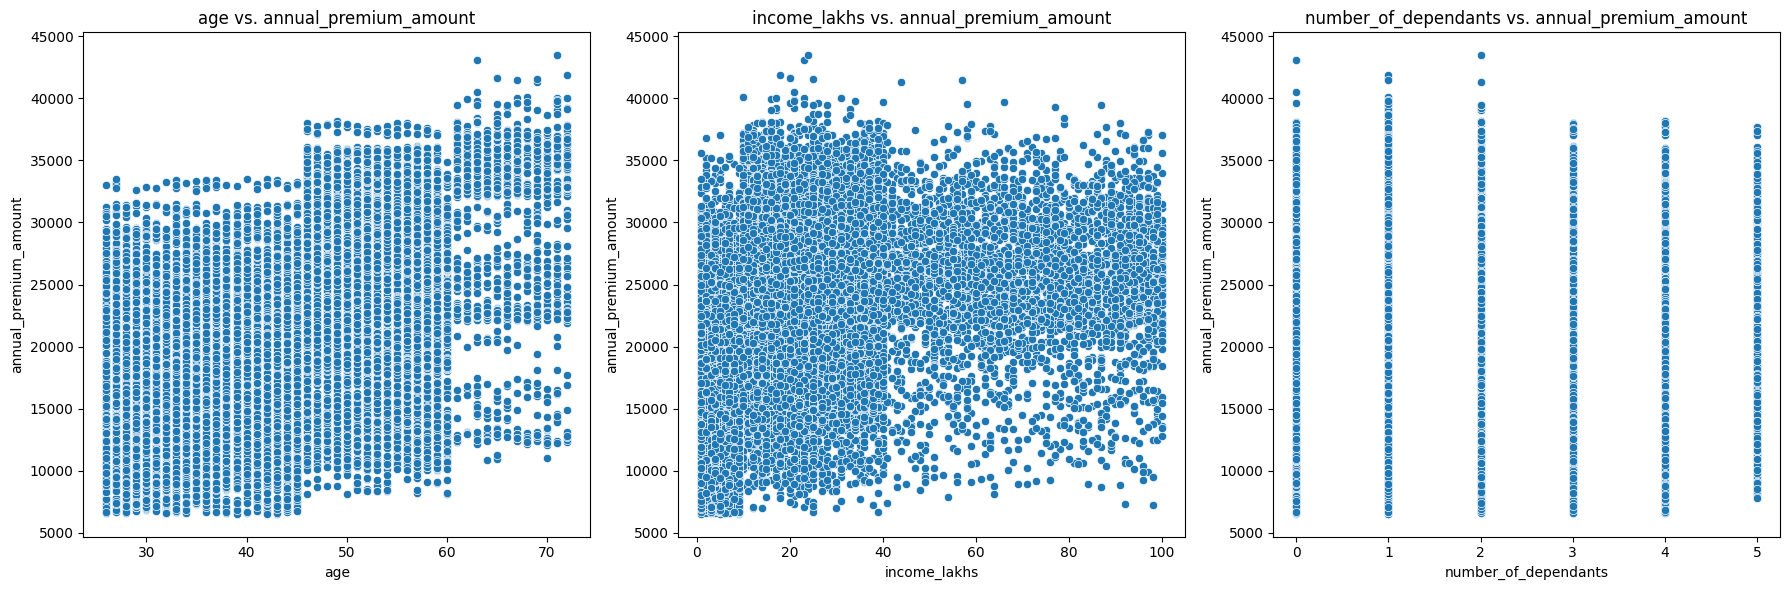

In [34]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']
target = 'annual_premium_amount'

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # 2x2 grid

for ax, col in zip(axes, numeric_features):
    sns.scatterplot(x=df2[col], y=df2[target], ax=ax)
    ax.set_title(f'{col} vs. {target}')
    ax.set_xlabel(col)
    ax.set_ylabel(target)

plt.tight_layout()
plt.show()

### Data Analysis : Categorical columns

In [35]:
df2.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


In [36]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']

categorical_cols

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [37]:
for col in categorical_cols:
    print(f' {col} : {df2[col].unique()}')

 gender : ['Male' 'Female']
 region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
 marital_status : ['Unmarried' 'Married']
 bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
 smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
 employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
 income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
 medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
 insurance_plan : ['Bronze' 'Silver' 'Gold']


In [38]:
df2['smoking_status'].replace({
        'Smoking=0': 'No Smoking',
        'Does Not Smoke': 'No Smoking',
        'Not Smoking': 'No Smoking',
}, inplace=True)
df2.smoking_status.unique()

C:\Users\Ahmad Fahim\AppData\Local\Temp\ipykernel_4232\1051042033.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

#### Univariate Analysis : Categorical columns

In [39]:
def barPlot(data, cols):
    n_cols = 3  # number of plots per row
    n_rows = (len(cols) + n_cols - 1) // n_cols  # ceiling division for rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # to loop easily

    for i, col in enumerate(cols):
        pct_count = data[col].value_counts(normalize=True)
        sns.barplot(x=pct_count.index, y=pct_count.values, ax=axes[i])
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Proportion')

    # Hide unused subplots if cols is not a multiple of 3
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

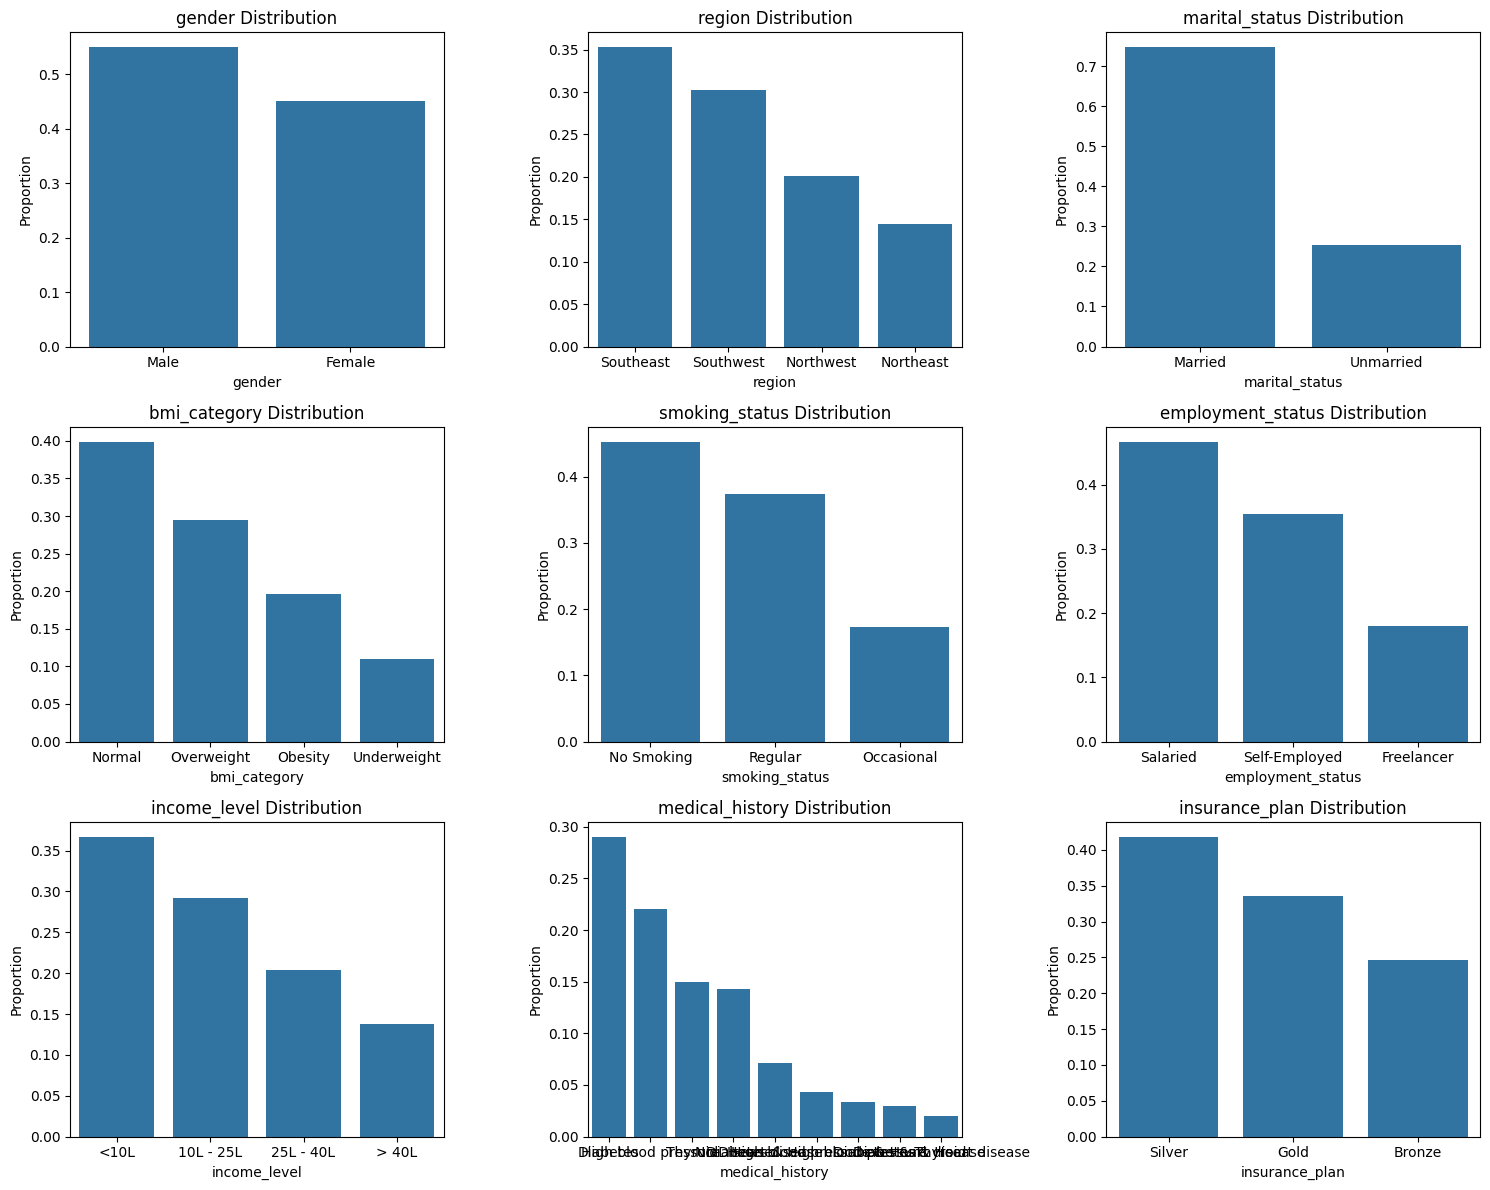

In [40]:
barPlot(df2, categorical_cols)

#### Bivariate Analysis : Categorical columns

In [41]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,799,3554,4354
25L - 40L,301,2631,3142
<10L,6054,527,4341
> 40L,214,3287,618


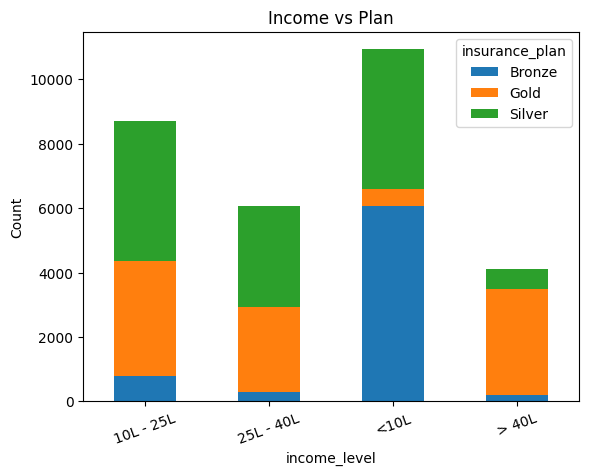

In [42]:
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.xticks(rotation=20)
plt.ylabel('Count')
plt.show()

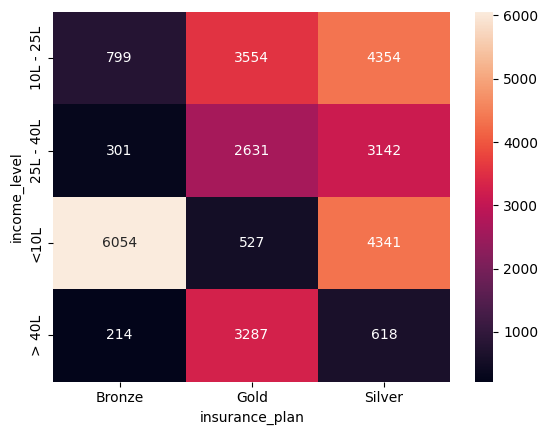

In [43]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.show()

## Feature Engineering

In [44]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [45]:
risk_scores_dictionary = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

In [46]:
df2[['disease1', 'disease2']] = df2.medical_history.str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,None


In [47]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

df2.head()

C:\Users\Ahmad Fahim\AppData\Local\Temp\ipykernel_4232\1524846493.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\Ahmad Fahim\AppData\Local\Temp\ipykernel_4232\1524846493.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,0


In [48]:
df2['total_risk_score'] = df2['disease1'].map(risk_scores_dictionary) + df2['disease2'].map(risk_scores_dictionary)

df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,6


In [49]:
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


In [50]:
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
26270,41,Female,Northwest,Married,3,Overweight,Regular,Salaried,10L - 25L,22,High blood pressure,Silver,20432,high blood pressure,none,6,0.428571
1078,51,Male,Southwest,Married,2,Obesity,No Smoking,Salaried,<10L,5,Diabetes,Silver,22327,diabetes,none,6,0.428571
6814,48,Male,Southwest,Married,2,Underweight,No Smoking,Self-Employed,25L - 40L,38,High blood pressure,Gold,26926,high blood pressure,none,6,0.428571
97,40,Female,Southeast,Married,4,Underweight,No Smoking,Salaried,25L - 40L,37,Diabetes & High blood pressure,Silver,18159,diabetes,high blood pressure,12,0.857143
21027,30,Female,Northwest,Married,3,Normal,No Smoking,Self-Employed,10L - 25L,25,Diabetes,Silver,15436,diabetes,none,6,0.428571


In [51]:
insurance_plan_dictionary = {
    'Bronze': 1,
    'Silver': 2,
    'Gold': 3,
}

df2['insurance_plan'] = df2['insurance_plan'].map(insurance_plan_dictionary)

In [52]:
df2['insurance_plan'].unique()

array([1, 2, 3])

In [53]:
income_level_dictionary = {
    '<10L': 1,
    '10L - 25L': 2,
    '25L - 40L': 3,
    '> 40L': 4,
}

df2['income_level'] = df2['income_level'].map(income_level_dictionary)

In [54]:
df2['income_level'].unique()

array([1, 2, 4, 3])

In [55]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,2,14,Diabetes,1,15610,diabetes,none,6,0.428571


In [56]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,diabetes,none,6,...,0,0,0,1,0,0,1,0,0,1


In [57]:
cols_to_drop = ['disease1', 'disease2', 'total_risk_score', 'medical_history']

df4 = df3.drop(cols_to_drop, axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


### Correlation Analysis

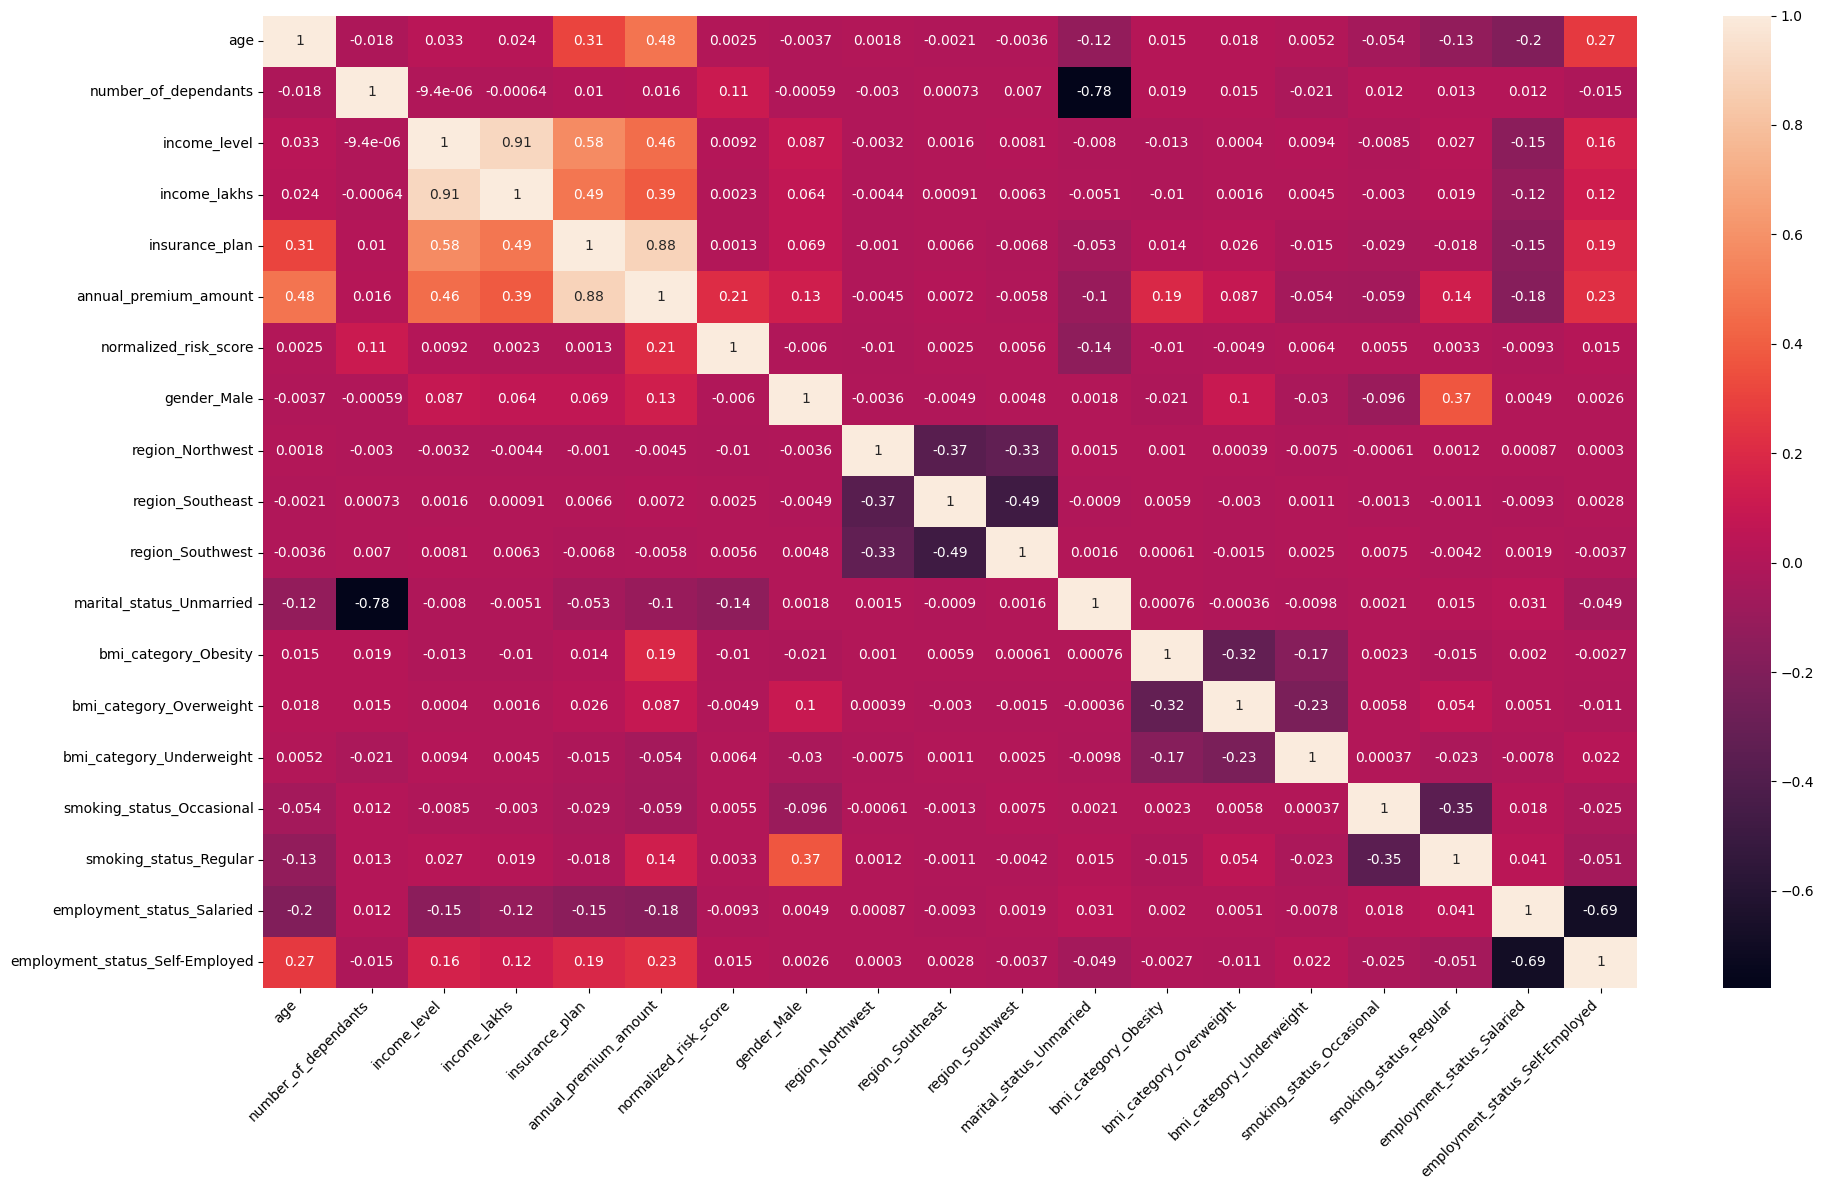

In [58]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

In [59]:
X = df4.drop(target, axis='columns')
y = df4[target]

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']

scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

In [60]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculateVIF(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [62]:
calculateVIF(X)

,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalized_risk_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


In [63]:
X = X.drop('income_level', axis='columns')

calculateVIF(X)

,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


In [64]:
X.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


## Model Training

In [65]:
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)

### Linear Regression

In [66]:
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

LinearRegression()

In [67]:
train_score = model_LR.score(X_train, y_train)
test_score = model_LR.score(X_test, y_test)

print(f'Training data score: {train_score}')
print(f'Test data score: {test_score}')

Training data score: 0.9534163989489616
Test data score: 0.9538448451629948


In [68]:
y_pred = model_LR.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'R2 Score: {r2}')

Mean Squared Error: 2183844.360312455
Root Mean Squared Error: 1477.7835972538248
R2 Score: 0.9517264834696174


In [69]:
X.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [70]:
model_LR.coef_

array([ 7016.23932829, -1311.76470171,  -708.19336921, 14835.98820801,
        6053.6241234 ,    37.55826883,   -55.25087215,   -19.62254288,
         -22.28967559,  -700.32019985,  3926.8127061 ,  1979.45604663,
         612.86623617,   837.3951011 ,  2800.66184334,   -45.49136706,
         243.07842087])

In [71]:
model_LR.intercept_

np.float64(5935.981289344605)

In [72]:
feature_importances = model_LR.coef_

coef_df = pd.DataFrame(feature_importances, columns=['Coefficients'], index=X.columns)
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
number_of_dependants,-1311.764702
income_lakhs,-708.193369
marital_status_Unmarried,-700.320200
region_Northwest,-55.250872
employment_status_Salaried,-45.491367
region_Southwest,-22.289676
region_Southeast,-19.622543
gender_Male,37.558269
employment_status_Self-Employed,243.078421
bmi_category_Underweight,612.866236


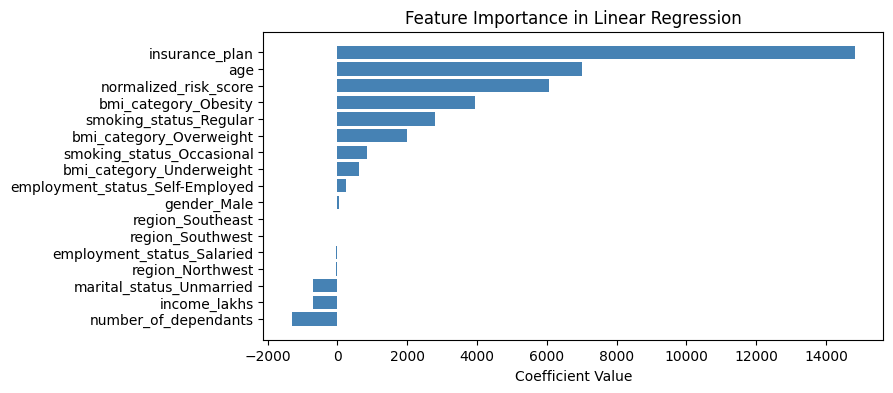

In [73]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df[ 'Coefficients'], color='steelblue') 
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression

In [74]:
model_RG = Ridge()
model_RG.fit(X_train, y_train)

Ridge()

In [75]:
train_score = model_RG.score(X_train, y_train)
test_score = model_RG.score(X_test, y_test)

print(f'Training data score: {train_score}')
print(f'Test data score: {test_score}')

Training data score: 0.9534162332209687
Test data score: 0.9538456995663842


In [76]:
y_pred = model_RG.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'R2 Score: {r2}')

Mean Squared Error: 2183803.933971563
Root Mean Squared Error: 1477.7699191591237
R2 Score: 0.9516938816327245


### XGBoost

In [77]:
from xgboost import XGBRegressor

model_XGB = XGBRegressor()
model_XGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [78]:
train_score = model_XGB.score(X_train, y_train)
test_score = model_XGB.score(X_test, y_test)

print(f'Training data score: {train_score}')
print(f'Test data score: {test_score}')

Training data score: 0.9986370801925659
Test data score: 0.9979538321495056


In [79]:
y_pred = model_XGB.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'R2 Score: {r2}')

Mean Squared Error: 96814.21875
Root Mean Squared Error: 311.1498332797239
R2 Score: 0.9979523420333862


In [80]:
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search= RandomizedSearchCV(model_XGB, param_grid, n_iter=10, cv=3, scoring='r2', random_state=4)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9977717598279318)

In [81]:
best_model = random_search.best_estimator_

In [82]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, columns=['Coefficients'], index=X.columns)
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
region_Southeast,0.000000
employment_status_Salaried,0.000000
marital_status_Unmarried,0.000000
region_Southwest,0.000000
employment_status_Self-Employed,0.000000
region_Northwest,0.000011
gender_Male,0.000019
number_of_dependants,0.000026
income_lakhs,0.000184
bmi_category_Underweight,0.003524


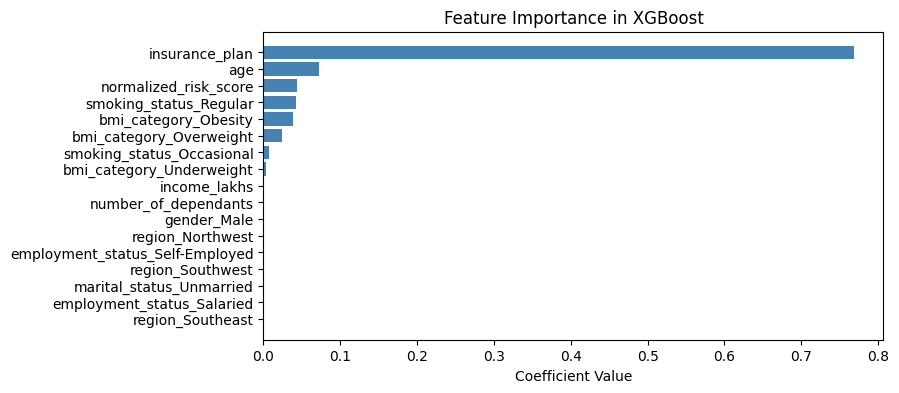

In [83]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df[ 'Coefficients'], color='steelblue') 
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

## Error Analysis

In [84]:
y_pred = best_model.predict(X_test)

In [85]:
residuals = y_pred - y_test
residuals_pct = residuals * 100 / y_test

In [86]:
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct,
})
results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26641.001953,-253.998047,-0.944406
14750,22734,22956.232422,222.232422,0.977533
19932,21198,21504.177734,306.177734,1.444371
29643,9100,9271.687500,171.687500,1.886676
17076,26434,26641.001953,207.001953,0.783090


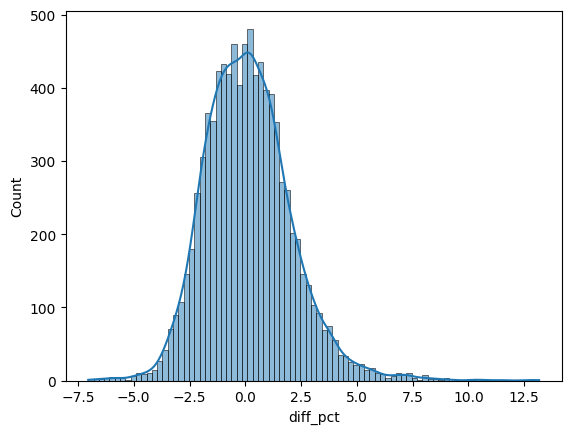

In [87]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.show()

In [88]:
threshold_margin_of_error = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct) > threshold_margin_of_error]

In [89]:
extreme_errors_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
print(f'Number of rows in results : {results_df.shape[0]}')
print(f'Number of rows in extreme error : {extreme_results_df.shape[0]}')
print(f'Percentage: {extreme_errors_pct}')

Number of rows in results : 8947
Number of rows in extreme error : 9
Percentage: 0.10059237733318431


In [90]:
results_df[np.abs(results_df.diff_pct) > threshold_margin_of_error].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct
7547,6538,7398.877441,860.877441,13.167290
6517,6552,7398.877441,846.877441,12.925480
12189,6571,7398.877441,827.877441,12.598957
8216,6635,7398.877441,763.877441,11.512848
21910,6651,7398.877441,747.877441,11.244586
13744,6691,7398.877441,707.877441,10.579546
21455,6699,7398.877441,699.877441,10.447491
10741,6706,7398.877441,692.877441,10.332202
11019,6715,7398.877441,683.877441,10.184325


In [91]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(5)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
7547,0.347826,0.2,0.080808,0.0,0.0,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0
12189,0.043478,0.6,0.060606,0.0,0.0,1,0,0,1,0,0,0,0,0,0,1,0
8216,0.152174,0.4,0.010101,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0
21455,0.239130,0.2,0.080808,0.0,0.0,1,1,0,0,1,0,0,0,0,0,0,0


In [92]:
import math

def compareHistPlot(data1, data2, cols):
    num_cols = len(cols)
    rows = math.ceil(num_cols / 3)  # Max 3 charts per row
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten in case of multiple rows

    for i, col in enumerate(cols):
        sns.histplot(data1[col], kde=True, label='Overall', color='blue', ax=axes[i])
        sns.histplot(data2[col], kde=True, label='Errors', alpha=0.5, color='red', ax=axes[i])
        axes[i].legend()
        axes[i].set_title(f'Distribution of {col} for Errors vs Overall')

    # Hide unused subplots (if any)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

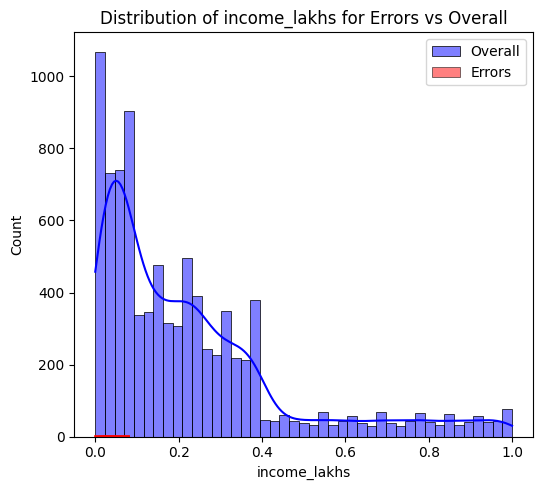

In [93]:
compareHistPlot(X_test, extreme_errors_df, ['income_lakhs'])

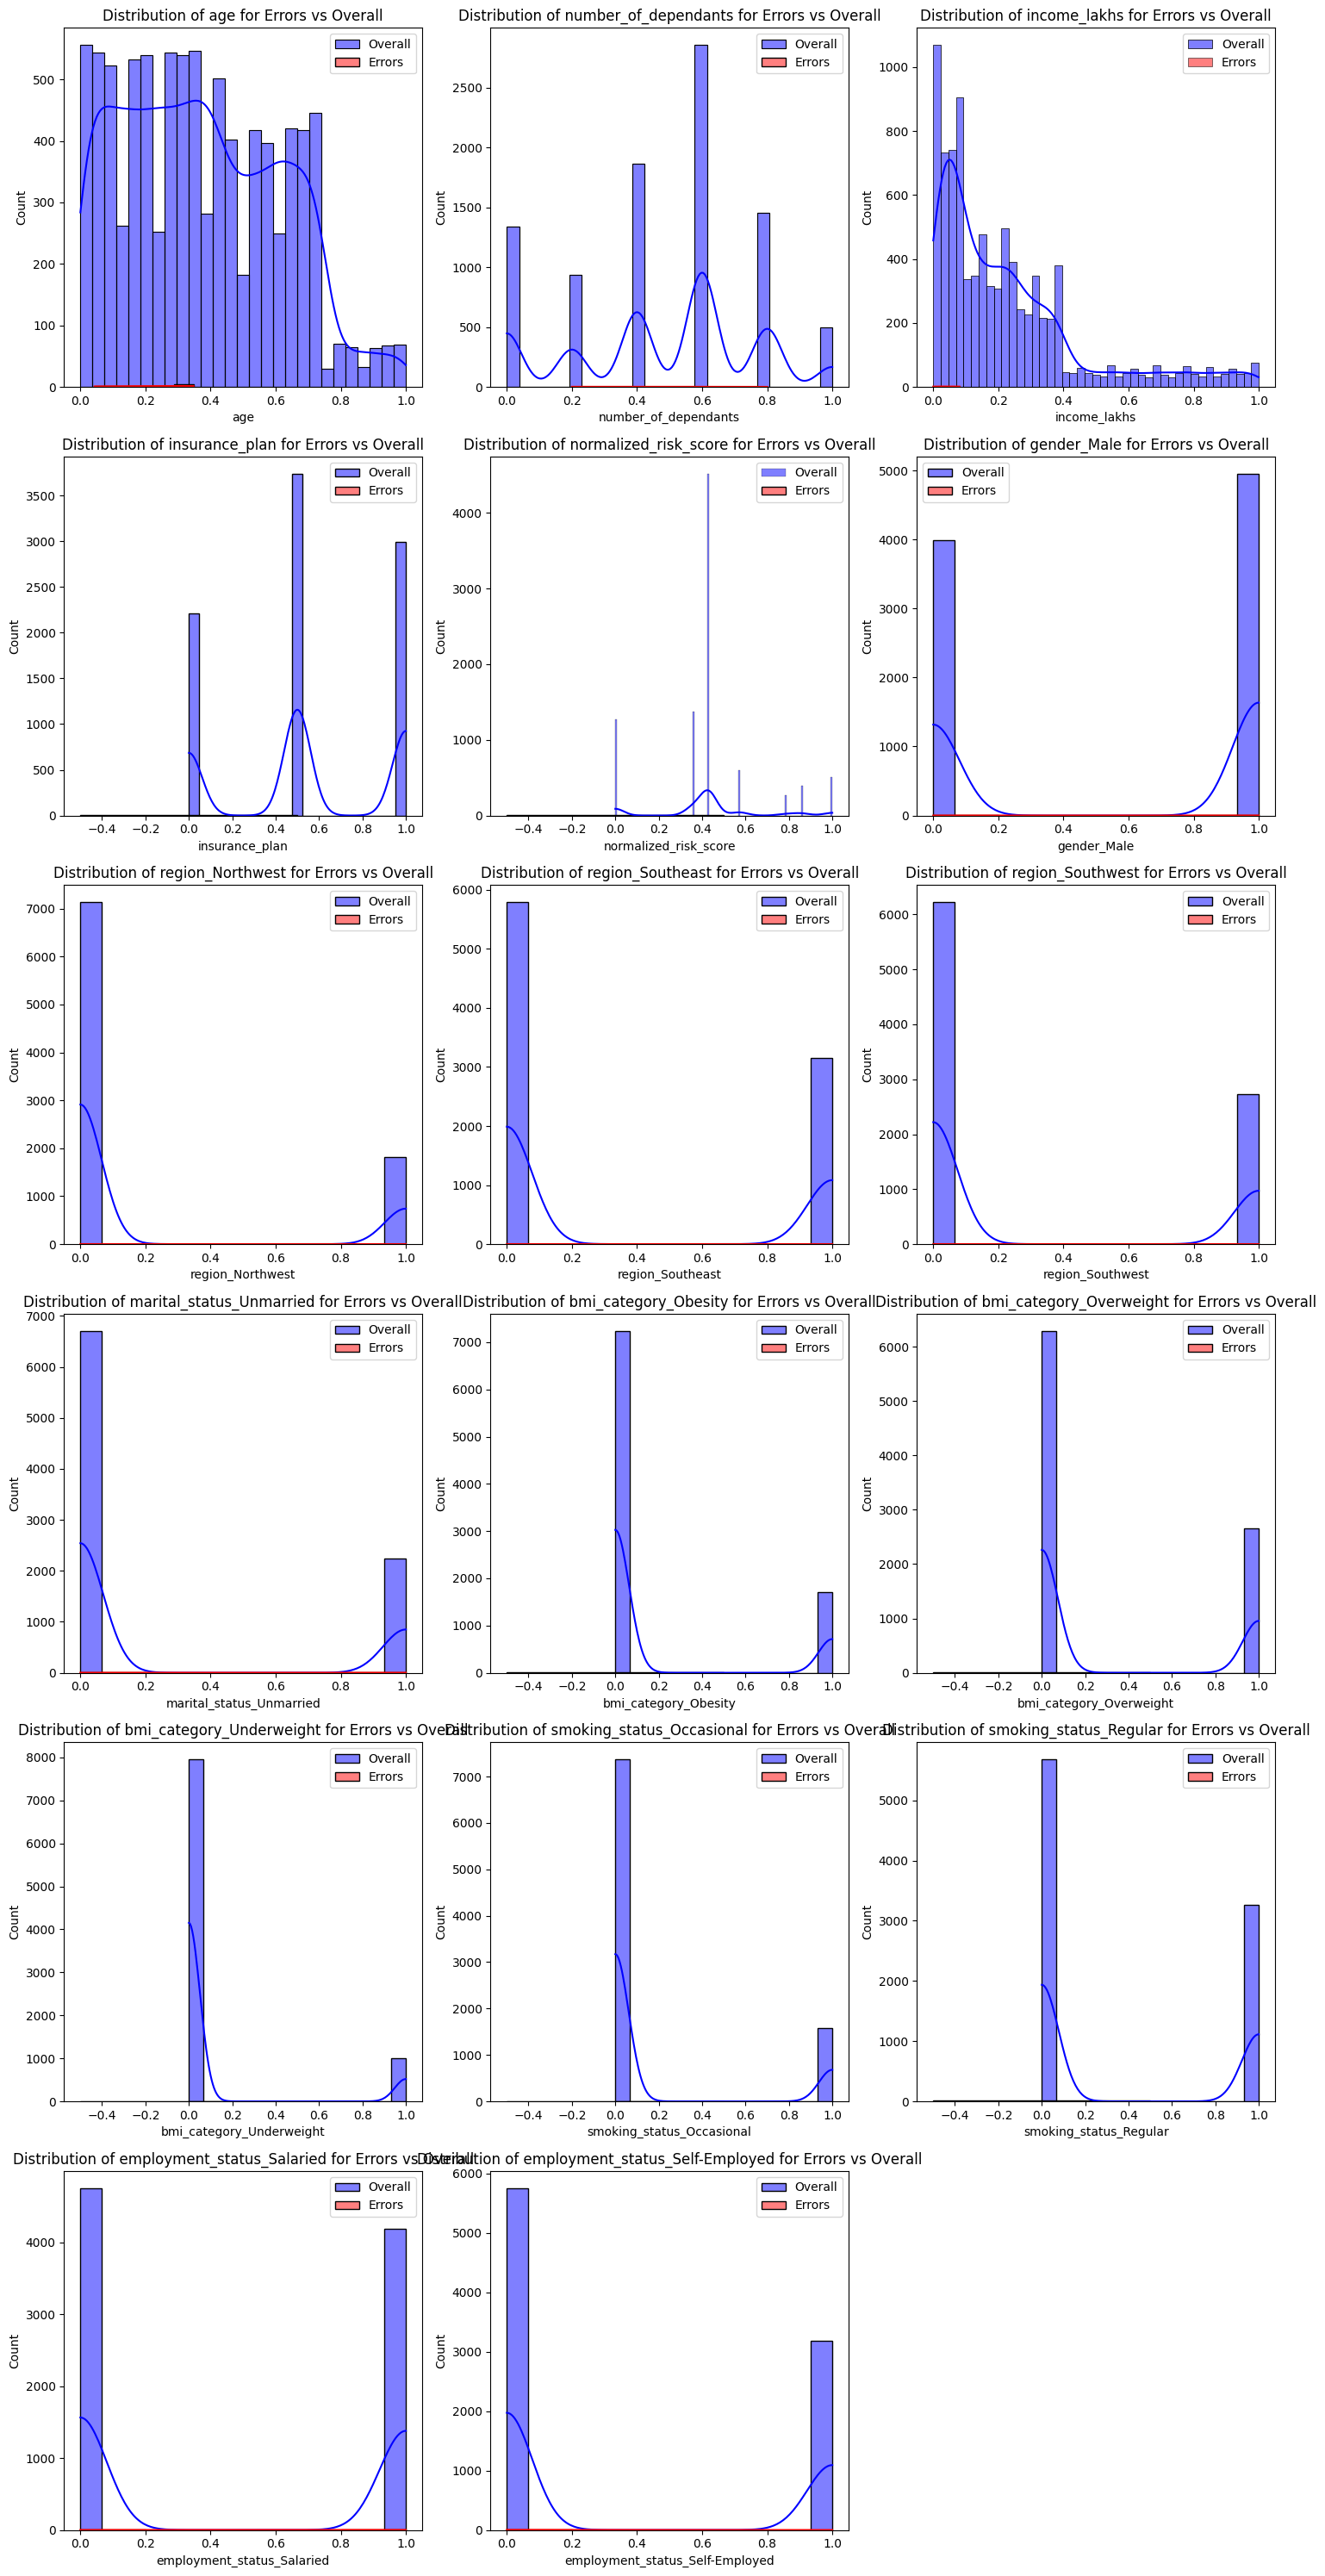

In [94]:
compareHistPlot(X_test, extreme_errors_df, X.columns)

In [95]:
extreme_errors_df['income_level'] = -1

In [96]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,42.0,1.0,-2.0,9.0,1.0
1,28.0,3.0,-2.0,3.0,1.0
2,28.0,3.0,-2.0,7.0,1.0
3,33.0,2.0,-2.0,2.0,1.0
4,37.0,1.0,-2.0,9.0,1.0
5,34.0,3.0,-2.0,1.0,1.0
6,40.0,4.0,-2.0,4.0,1.0
7,40.0,1.0,-2.0,9.0,1.0
8,40.0,1.0,-2.0,4.0,1.0


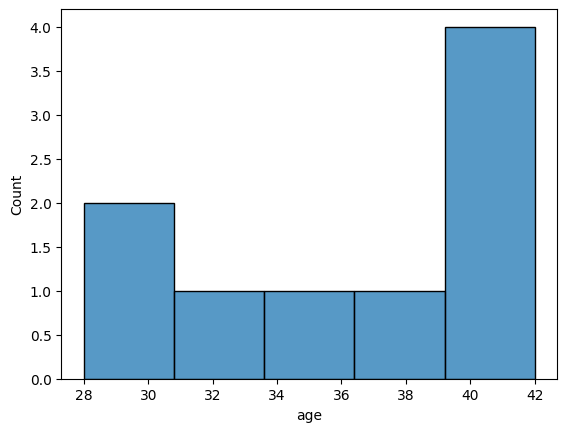

In [97]:
sns.histplot(df_reversed, x='age')
plt.show()

In [100]:
df_reversed['age'].quantile(0.5)

np.float64(37.0)